In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
##Calculate the total cost
from sklearn.metrics import accuracy_score
#accuracy_score(test_labels, y_pred)
## Confusion matrix
from sklearn.metrics import confusion_matrix
#confusion_matrix(test_labels, y_pred)

In [2]:
!pip install xgboost
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics

from matplotlib import pyplot


In [4]:
### Functions

### Defining the Cost Function (Evaluation Function)

In [5]:
def calculate_cost(test_labels,y_pred):
  confusion_matrix(test_labels, y_pred)
  con_mat = confusion_matrix(test_labels, y_pred)
  cost_1 = con_mat[0][1]
  cost_2 = con_mat[1][0]
  total_pred = con_mat[0][0] + con_mat[0][1] + con_mat[1][0] + con_mat[1][1]
  accur = (con_mat[0][0] / total_pred ) * 100
  total_cost = (cost_1 * 10) + (cost_2*500)
  # accuracy: (tp + tn) / (p + n)
  accuracy = accuracy_score(test_labels, y_pred)
  print('Accuracy: %f' % accuracy)
  # precision tp / (tp + fp)
  precision = precision_score(test_labels, y_pred)
  print('Precision: %f' % precision)
  # recall: tp / (tp + fn)
  recall = recall_score(test_labels, y_pred)
  print('Recall: %f' % recall)
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(test_labels, y_pred)
  print('F1 score: %f' % f1)


  # ROC AUC
  auc = roc_auc_score(test_labels, y_pred)
  print('ROC AUC: %f' % auc)
  # confusion matrix
  matrix = confusion_matrix(test_labels, y_pred)
  print(matrix)
  return total_cost, cost_1, cost_2, accur


## As chi squred does not accept negative we need to make all the values between zero and 1
## Also some of algorithm works better when do this step ahead
def MinMaxScaler_def(features,feature_list):
  scaler = MinMaxScaler()
  scaler.fit(features)
  train_features = pd.DataFrame(scaler.transform(features), columns=feature_list)
  return train_features


def selectKBest(k_best,train_features,labels,test_features):
  selectKBest = SelectKBest(chi2, k_best)
  selectKBest.fit(train_features, labels)
  best_train_features = selectKBest.transform(train_features)

  idxs_selected = selectKBest.get_support(indices=True)
  best_train_features = train_features.iloc[:,idxs_selected]
  best_test_features = test_features.iloc[:,idxs_selected]

  return best_train_features,best_test_features

 Train Data

In [6]:
train_raw = pd.read_csv('/content/aps_failure_training_set.csv',na_values='na')
train_processed = pd.read_csv('/content/aps_failure_training_set_processed_8bit.csv',na_values='na')
train_processed["class"] = train_raw["class"]

In [7]:
train_processed.columns

Index(['class', 'aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000',
       'ag_000', 'ag_001', 'ag_002',
       ...
       'ee_002', 'ee_003', 'ee_004', 'ee_005', 'ee_006', 'ee_007', 'ee_008',
       'ee_009', 'ef_000', 'eg_000'],
      dtype='object', length=171)

In [8]:
test_raw = pd.read_csv('/content/aps_failure_test_set.csv',na_values='na')
test_processed = pd.read_csv('/content/aps_failure_test_set_processed_8bit.csv',na_values='na')
test_processed["class"] = test_raw["class"]

In [9]:
test_processed.columns

Index(['class', 'aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000',
       'ag_000', 'ag_001', 'ag_002',
       ...
       'ee_002', 'ee_003', 'ee_004', 'ee_005', 'ee_006', 'ee_007', 'ee_008',
       'ee_009', 'ef_000', 'eg_000'],
      dtype='object', length=171)

**All Data**

In [10]:
all = train_processed.append(test_processed)

In [11]:
### 170 features
### 76000 instances
all.shape

(76000, 171)

In [12]:
labelencoder = LabelEncoder()

# Assigning numerical values and storing in another column
all['class_labeled'] = labelencoder.fit_transform(all['class'])
The_class = all[['class_labeled']]
all = all.drop('class',axis=1)
#aps_failure_processed.head()

In [13]:
## all data
ozero_counter = 0
oone_counter = 0
for i in all['class_labeled']:
    if i == 0 :
        ozero_counter+=1
    if i == 1:
        oone_counter+=1
print("Original Zeros count is",ozero_counter)
print("Original Ones count is",oone_counter)

Original Zeros count is 74625
Original Ones count is 1375


Text(0, 0.5, ' count')

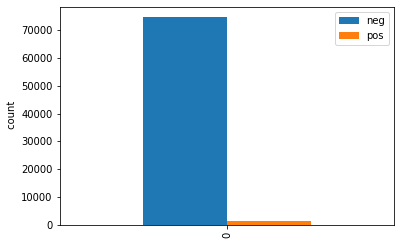

In [14]:
all_df = pd.DataFrame({'neg':[74625],'pos':[1375]})
all_df.plot(kind='bar')
all_df.index = ['label']
plt.ylabel(' count')

In [15]:
#from google.colab import drive
#drive.mount('/content/drive')

**Cleaning and preparation**

In [16]:
## 80% , 10% , 10%
from sklearn.model_selection import train_test_split

# Let's say we want to split the data in 80:10:10 for train:valid:test dataset
train_size=0.8

X = all.drop(columns = ['class_labeled']).copy()
y = all['class_labeled']

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

print("Train shape: ")
print(X_train.shape), print(y_train.shape)
print("Validation shape: ")
print(X_valid.shape), print(y_valid.shape)
print("Test shape: ")
print(X_test.shape), print(y_test.shape)

Train shape: 
(60800, 170)
(60800,)
Validation shape: 
(7600, 170)
(7600,)
Test shape: 
(7600, 170)
(7600,)


(None, None)

## **Train**

In [17]:
# Labels are the values we want to predict
train_labels = np.array(y_train)
# Remove the labels from the features
# axis 1 refers to the columns
train_features = X_train
# Saving feature names for later use
train_feature_list = list(train_features.columns)
# Convert to numpy array
train_features = np.array(train_features)

In [18]:
train_features.shape

(60800, 170)

In [19]:
y_train.shape

(60800,)

In [20]:
train_labels.shape

(60800,)

# **Validation**

In [21]:
# Labels are the values we want to predict
validation_labels = np.array(y_valid)
# Remove the labels from the features
# axis 1 refers to the columns
validation_features = X_valid
# Saving feature names for later use
validation_feature_list = list(validation_features.columns)
# Convert to numpy array
validation_features = np.array(validation_features)

In [22]:
validation_features.shape

(7600, 170)

In [23]:
validation_labels.shape

(7600,)

# **Test**

In [24]:
# Labels are the values we want to predict
test_labels = np.array(y_test)
# Remove the labels from the features
# axis 1 refers to the columns
test_features = X_test
# Saving feature names for later use
test_feature_list = list(test_features.columns)
# Convert to numpy array
test_features = np.array(test_features)

In [25]:
test_features.shape

(7600, 170)

In [26]:
test_labels.shape

(7600,)

In [27]:
## Check with shapes
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Validation Features Shape:', validation_features.shape)
print('Validation Labels Shape:', validation_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)



Training Features Shape: (60800, 170)
Training Labels Shape: (60800,)
Validation Features Shape: (7600, 170)
Validation Labels Shape: (7600,)
Testing Features Shape: (7600, 170)
Testing Labels Shape: (7600,)


In [28]:
train_labels

array([0, 0, 0, ..., 0, 0, 0])

### Imbalanced Training handling using SMOTE

In [29]:
import imblearn 
from collections import Counter
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

#Print 0s and 1s original count 
ozero_counter = 0
oone_counter = 0
for i in train_labels:
    if i == 0 :
        ozero_counter+=1
    if i == 1:
        oone_counter+=1
print("Original Zeros count is",ozero_counter)
print("Original Ones count is",oone_counter)

# transform the dataset
oversample = SMOTE()
train_features, train_labels = oversample.fit_resample(train_features, train_labels)

#Print 0s and 1s after SMOTE
zero_counter = 0
one_counter = 0
for i in train_labels:
    if i == 0 :
        zero_counter+=1
    if i ==1:
        one_counter+=1
print("After SMOTE Zeros count is",zero_counter)
print("After SMOTE Ones count is",one_counter)

Original Zeros count is 59685
Original Ones count is 1115


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


After SMOTE Zeros count is 59685
After SMOTE Ones count is 59685


In [30]:
train_features.shape

(119370, 170)

In [31]:
train_labels.shape

(119370,)

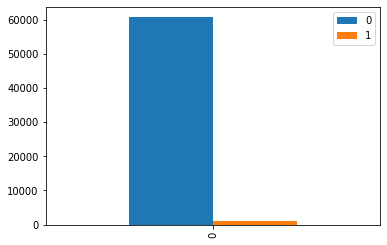

In [32]:
##befor
before_df = pd.DataFrame({'0':[60800],'1':[1075]})
before_df.plot(kind='bar')

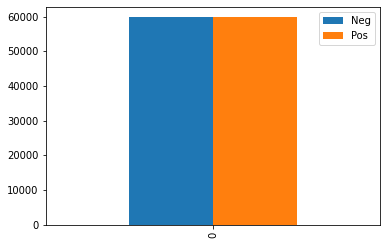

In [33]:
##after
after_df = pd.DataFrame({'Neg':[59725],'Pos':[59725]})
after_df.plot(kind='bar')


**CHI SQUARE**

In [34]:
## As chi squred does not accept negative we need to make all the values between zero and 1
## Also some of algorithm works better when do this step ahead
def MinMaxScaler_def(features,feature_list):
  scaler = MinMaxScaler()
  scaler.fit(features)
  train_features = pd.DataFrame(scaler.transform(features), columns=feature_list)
  return train_features

In [35]:
def selectKBest(k_best,train_features,validation_features,test_features):
  selectKBest = SelectKBest(chi2, k_best)
  selectKBest.fit(train_features, train_labels)
  best_train_features = selectKBest.transform(train_features)

  idxs_selected = selectKBest.get_support(indices=True)
  best_train_features = train_features.iloc[:,idxs_selected]
  best_validation_features = validation_features.iloc[:,idxs_selected]
  best_test_features = test_features.iloc[:,idxs_selected]

  return best_train_features,best_validation_features,best_test_features

In [36]:
##Main
train_features_scaled = MinMaxScaler_def( train_features ,train_feature_list)
validation_features_scaled = MinMaxScaler_def(validation_features, validation_feature_list)
test_features_scaled = MinMaxScaler_def(test_features,test_feature_list)

In [37]:
best_train_features,best_validation_features,best_test_features = selectKBest(40,train_features_scaled,validation_features_scaled,test_features_scaled)

In [38]:
best_train_features.shape

(119370, 40)

In [39]:
best_validation_features.shape

(7600, 40)

In [40]:
best_test_features.shape

(7600, 40)

### **PCA**

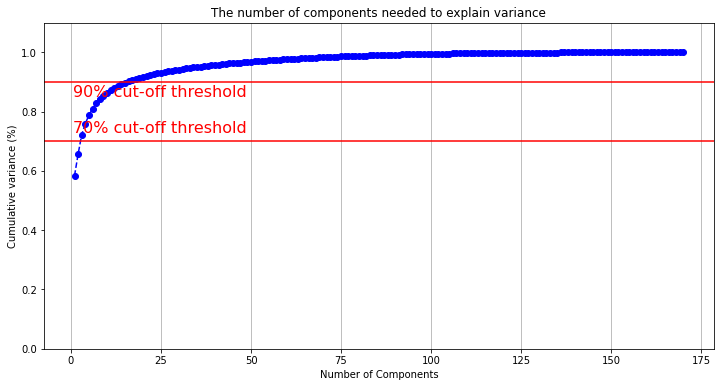

In [41]:
from sklearn.decomposition import PCA
pca = PCA().fit(train_features)
#remove ; to see the output
pca.explained_variance_ratio_;

plt.rcParams["figure.figsize"] = (12,6)
fig, ax = plt.subplots()
xi = np.arange(1, 171, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')
plt.axhline(y=0.70, color='r', linestyle='-')
plt.text(0.5, 0.73, '70% cut-off threshold', color = 'red', fontsize=16)
plt.axhline(y=0.90, color='r', linestyle='-')
plt.text(0.5, 0.85, '90% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [42]:
n_comp=[0.70,0.75,0.80,0.85,0.90]

**TEST AND TRAIN VALUES FOR VARIANCE**

In [43]:
#70%
pca = PCA(n_components = n_comp[0],random_state = 42)
pca.fit(train_features)
x_train_new_0 = pca.transform(train_features)
X_valid_0 = pca.transform(X_valid)
x_test_0 = pca.transform(X_test)
print("Number of features after PCA = ", x_test_0.shape[1])

Number of features after PCA =  3


In [44]:
#75
pca = PCA(n_components = n_comp[1],random_state = 42)
pca.fit(X_train)
x_train_new_1 = pca.transform(train_features)
X_valid_1 = pca.transform(X_valid)
x_test_1 = pca.transform(X_test)
print("Number of features after PCA = ", x_test_1.shape[1])

Number of features after PCA =  4


In [45]:
#80
pca = PCA(n_components = n_comp[2],random_state = 42)
pca.fit(X_train)
x_train_new_2 = pca.transform(train_features)
X_valid_2 = pca.transform(X_valid)
x_test_2 = pca.transform(X_test)
print("Number of features after PCA = ", x_test_2.shape[1])

Number of features after PCA =  6


In [46]:
#85
pca = PCA(n_components = n_comp[3],random_state = 42)
pca.fit(X_train)
x_train_new_3 = pca.transform(train_features)
X_valid_3 = pca.transform(X_valid)
x_test_3 = pca.transform(X_test)
print("Number of features after PCA = ", x_test_3.shape[1])

Number of features after PCA =  10


In [47]:
#90
pca = PCA(n_components = n_comp[4],random_state = 42)
pca.fit(X_train)
x_train_new_4 = pca.transform(train_features)
X_valid_4 = pca.transform(X_valid)
x_test_4 = pca.transform(X_test)
print("Number of features after PCA = ", x_test_4.shape[1])

Number of features after PCA =  18


### Plain RF

In [48]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf = RandomForestClassifier(n_estimators=100 )

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(train_features,train_labels)

y_pred=clf.predict(validation_features)
rf_cost = calculate_cost(test_labels,y_pred)
print(rf_cost)

Accuracy: 0.964474
Precision: 0.007692
Recall: 0.007042
F1 score: 0.007353
ROC AUC: 0.494873
[[7329  129]
 [ 141    1]]
(71790, 129, 141, 96.4342105263158)


In [49]:
#testing 70
y_pred=clf.predict(test_features)
rf_pca_cost_0 = calculate_cost(test_labels,y_pred)
print(rf_pca_cost_0)

Accuracy: 0.991447
Precision: 0.789474
Recall: 0.739437
F1 score: 0.763636
ROC AUC: 0.867841
[[7430   28]
 [  37  105]]
(18780, 28, 37, 97.76315789473684)


## **1. Training with PCA**

### RF + PCA

In [50]:
train_labels.shape

(119370,)

In [51]:
x_train_new_0.shape

(119370, 3)

In [52]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf = RandomForestClassifier(n_estimators=100 )

#Train the model using the training sets y_pred=clf.predict(X_test)
#70%
clf.fit(x_train_new_0,train_labels)

#validation
y_pred=clf.predict(X_valid_0)
rf_pca_cost_0 = calculate_cost(validation_labels,y_pred)
print(rf_pca_cost_0)

Accuracy: 0.953553
Precision: 0.233560
Recall: 0.872881
F1 score: 0.368515
ROC AUC: 0.913853
[[7144  338]
 [  15  103]]
(10880, 338, 15, 94.0)


In [53]:
#testing 70
y_pred=clf.predict(x_test_0)
rf_pca_cost_0 = calculate_cost(test_labels,y_pred)
print(rf_pca_cost_0)

Accuracy: 0.950921
Precision: 0.257862
Recall: 0.866197
F1 score: 0.397415
ROC AUC: 0.909366
[[7104  354]
 [  19  123]]
(13040, 354, 19, 93.47368421052632)


In [54]:

#Create a Gaussian Classifier
clf = RandomForestClassifier(n_estimators=100 )

#Train the model using the training sets y_pred=clf.predict(X_test)
#75%
clf.fit(x_train_new_1,train_labels)

y_pred=clf.predict(X_valid_1)
rf_pca_cost_1 = calculate_cost(validation_labels,y_pred)
print(rf_pca_cost_1)

Accuracy: 0.958684
Precision: 0.247423
Recall: 0.813559
F1 score: 0.379447
ROC AUC: 0.887266
[[7190  292]
 [  22   96]]
(13920, 292, 22, 94.60526315789474)


In [55]:
#testing 75
y_pred=clf.predict(x_test_1)
rf_pca_cost_1 = calculate_cost(test_labels,y_pred)
print(rf_pca_cost_1)

Accuracy: 0.960395
Precision: 0.300752
Recall: 0.845070
F1 score: 0.443623
ROC AUC: 0.903830
[[7179  279]
 [  22  120]]
(13790, 279, 22, 94.46052631578948)


In [56]:
#Create a Gaussian Classifier
clf = RandomForestClassifier(n_estimators=100 )

#Train the model using the training sets y_pred=clf.predict(X_test)
#80%
clf.fit(x_train_new_2,train_labels)

y_pred=clf.predict(X_valid_2)
rf_pca_cost_2 = calculate_cost(validation_labels,y_pred)
print(rf_pca_cost_2)

Accuracy: 0.965789
Precision: 0.284848
Recall: 0.796610
F1 score: 0.419643
ROC AUC: 0.882534
[[7246  236]
 [  24   94]]
(14360, 236, 24, 95.34210526315789)


In [57]:
#testing 80
y_pred=clf.predict(x_test_2)
rf_pca_cost_2 = calculate_cost(test_labels,y_pred)
print(rf_pca_cost_2)

Accuracy: 0.967237
Precision: 0.341246
Recall: 0.809859
F1 score: 0.480167
ROC AUC: 0.890046
[[7236  222]
 [  27  115]]
(15720, 222, 27, 95.21052631578948)


In [58]:
#Create a Gaussian Classifier
clf = RandomForestClassifier(n_estimators=100 )

#Train the model using the training sets y_pred=clf.predict(X_test)
#85%
clf.fit(x_train_new_3,train_labels)

y_pred=clf.predict(X_valid_3)
rf_pca_cost_3 = calculate_cost(validation_labels,y_pred)
print(rf_pca_cost_3)

Accuracy: 0.972500
Precision: 0.333333
Recall: 0.771186
F1 score: 0.465473
ROC AUC: 0.873431
[[7300  182]
 [  27   91]]
(15320, 182, 27, 96.05263157894737)


In [59]:
#testing 85
y_pred=clf.predict(x_test_3)
rf_pca_cost_3 = calculate_cost(test_labels,y_pred)
print(rf_pca_cost_3)

Accuracy: 0.973553
Precision: 0.395018
Recall: 0.781690
F1 score: 0.524823
ROC AUC: 0.879448
[[7288  170]
 [  31  111]]
(17200, 170, 31, 95.89473684210526)


In [60]:
#Create a Gaussian Classifier
clf = RandomForestClassifier(n_estimators=100 )

#Train the model using the training sets y_pred=clf.predict(X_test)
#90%
clf.fit(x_train_new_4,train_labels)

y_pred=clf.predict(X_valid_4)
rf_pca_cost_4 = calculate_cost(validation_labels,y_pred)
print(rf_pca_cost_4)

Accuracy: 0.980395
Precision: 0.422111
Recall: 0.711864
F1 score: 0.529968
ROC AUC: 0.848247
[[7367  115]
 [  34   84]]
(18150, 115, 34, 96.9342105263158)


In [61]:
#testing 90
y_pred=clf.predict(x_test_4)
rf_pca_cost_4 = calculate_cost(test_labels,y_pred)
print(rf_pca_cost_4)

Accuracy: 0.982105
Precision: 0.514151
Recall: 0.767606
F1 score: 0.615819
ROC AUC: 0.876897
[[7355  103]
 [  33  109]]
(17530, 103, 33, 96.77631578947368)


### GB + PCA

In [62]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,\
                                 max_depth=1, random_state=0)
#Train the model using the training sets y_pred=clf.predict(X_test)
#70%
clf.fit(x_train_new_0,train_labels)

#validation
y_pred=clf.predict(X_valid_0)
gb_pca_cost_0 = calculate_cost(validation_labels,y_pred)
print(gb_pca_cost_0)

Accuracy: 0.931316
Precision: 0.175241
Recall: 0.923729
F1 score: 0.294595
ROC AUC: 0.927582
[[6969  513]
 [   9  109]]
(9630, 513, 9, 91.69736842105263)


In [63]:
#testing 70
y_pred=clf.predict(x_test_0)
gb_pca_cost_0 = calculate_cost(test_labels,y_pred)
print(gb_pca_cost_0)

Accuracy: 0.930789
Precision: 0.208207
Recall: 0.964789
F1 score: 0.342500
ROC AUC: 0.947465
[[6937  521]
 [   5  137]]
(7710, 521, 5, 91.27631578947368)


In [64]:
#75%
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,\
                                 max_depth=1, random_state=0)
#Train the model using the training sets y_pred=clf.predict(X_test)
#75%
clf.fit(x_train_new_1,train_labels)

#validation
y_pred=clf.predict(X_valid_1)
gb_pca_cost_1 = calculate_cost(validation_labels,y_pred)
print(gb_pca_cost_1)

Accuracy: 0.932763
Precision: 0.176277
Recall: 0.906780
F1 score: 0.295172
ROC AUC: 0.919976
[[6982  500]
 [  11  107]]
(10500, 500, 11, 91.86842105263158)


In [65]:
#testing 75
y_pred=clf.predict(x_test_1)
gb_pca_cost_1 = calculate_cost(test_labels,y_pred)
print(gb_pca_cost_1)

Accuracy: 0.933289
Precision: 0.213501
Recall: 0.957746
F1 score: 0.349166
ROC AUC: 0.945285
[[6957  501]
 [   6  136]]
(8010, 501, 6, 91.53947368421052)


In [66]:
#80%
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,\
                                 max_depth=1, random_state=0)

#Train the model using the training sets y_pred=clf.predict(X_test)
#80%
clf.fit(x_train_new_2,train_labels)

#validation
y_pred=clf.predict(X_valid_2)
gb_pca_cost_2 = calculate_cost(validation_labels,y_pred)
print(gb_pca_cost_2)

Accuracy: 0.933289
Precision: 0.179572
Recall: 0.923729
F1 score: 0.300690
ROC AUC: 0.928585
[[6984  498]
 [   9  109]]
(9480, 498, 9, 91.89473684210526)


In [67]:
#testing 80
y_pred=clf.predict(x_test_2)
gb_pca_cost_2 = calculate_cost(test_labels,y_pred)
print(gb_pca_cost_2)

Accuracy: 0.935921
Precision: 0.220421
Recall: 0.957746
F1 score: 0.358366
ROC AUC: 0.946626
[[6977  481]
 [   6  136]]
(7810, 481, 6, 91.80263157894737)


In [68]:
#85%
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,\
                                 max_depth=1, random_state=0)


#Train the model using the training sets y_pred=clf.predict(X_test)
#80%
clf.fit(x_train_new_3,train_labels)

#validation
y_pred=clf.predict(X_valid_3)
gb_pca_cost_3 = calculate_cost(validation_labels,y_pred)
print(gb_pca_cost_3)

Accuracy: 0.945132
Precision: 0.209709
Recall: 0.915254
F1 score: 0.341232
ROC AUC: 0.930429
[[7075  407]
 [  10  108]]
(9070, 407, 10, 93.0921052631579)


In [69]:
#testing 85
y_pred=clf.predict(x_test_3)
gb_pca_cost_3 = calculate_cost(test_labels,y_pred)
print(gb_pca_cost_3)

Accuracy: 0.947895
Precision: 0.257634
Recall: 0.950704
F1 score: 0.405405
ROC AUC: 0.949273
[[7069  389]
 [   7  135]]
(7390, 389, 7, 93.01315789473684)


In [70]:
#90%
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,\
                                 max_depth=1, random_state=0)


#Train the model using the training sets y_pred=clf.predict(X_test)
#80%
clf.fit(x_train_new_4,train_labels)

#validation
y_pred=clf.predict(X_valid_4)
gb_pca_cost_4 = calculate_cost(validation_labels,y_pred)
print(gb_pca_cost_4)


Accuracy: 0.947105
Precision: 0.212551
Recall: 0.889831
F1 score: 0.343137
ROC AUC: 0.918920
[[7093  389]
 [  13  105]]
(10390, 389, 13, 93.32894736842105)


In [71]:
#testing 90
y_pred=clf.predict(x_test_4)
gb_pca_cost_4 = calculate_cost(test_labels,y_pred)
print(gb_pca_cost_4)

Accuracy: 0.953289
Precision: 0.278586
Recall: 0.943662
F1 score: 0.430177
ROC AUC: 0.948567
[[7111  347]
 [   8  134]]
(7470, 347, 8, 93.56578947368422)


### XGBoost + PCA

In [72]:
from sklearn.ensemble import GradientBoostingClassifier
# fit model no training data
clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.4,
              learning_rate=0.15, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

#Train the model using the training sets y_pred=clf.predict(X_test)
#70%
clf.fit(x_train_new_0,train_labels)

#validation
y_pred=clf.predict(X_valid_0)
xgb_pca_cost_0 = calculate_cost(validation_labels,y_pred)
print(xgb_pca_cost_0)

Accuracy: 0.927105
Precision: 0.164615
Recall: 0.906780
F1 score: 0.278646
ROC AUC: 0.917103
[[6939  543]
 [  11  107]]
(10930, 543, 11, 91.30263157894737)


In [73]:
#testing 70
y_pred=clf.predict(x_test_0)
xgb_pca_cost_0 = calculate_cost(test_labels,y_pred)
print(xgb_pca_cost_0)

Accuracy: 0.925789
Precision: 0.193314
Recall: 0.936620
F1 score: 0.320482
ROC AUC: 0.931101
[[6903  555]
 [   9  133]]
(10050, 555, 9, 90.82894736842105)


In [74]:
#75%
# fit model no training data
clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.4,
              learning_rate=0.15, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

#Train the model using the training sets y_pred=clf.predict(X_test)
#75%
clf.fit(x_train_new_1,train_labels)

#validation
y_pred=clf.predict(X_valid_1)
xgb_pca_cost_1 = calculate_cost(validation_labels,y_pred)
print(xgb_pca_cost_1)

Accuracy: 0.921974
Precision: 0.150221
Recall: 0.864407
F1 score: 0.255960
ROC AUC: 0.893644
[[6905  577]
 [  16  102]]
(13770, 577, 16, 90.85526315789474)


In [75]:
#testing 75
y_pred=clf.predict(x_test_1)
xgb_pca_cost_1 = calculate_cost(test_labels,y_pred)
print(xgb_pca_cost_1)

Accuracy: 0.924342
Precision: 0.190272
Recall: 0.936620
F1 score: 0.316290
ROC AUC: 0.930364
[[6892  566]
 [   9  133]]
(10160, 566, 9, 90.6842105263158)


In [76]:
#80%
# fit model no training data
clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.4,
              learning_rate=0.15, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


#Train the model using the training sets y_pred=clf.predict(X_test)
#80%
clf.fit(x_train_new_2,train_labels)

#validation
y_pred=clf.predict(X_valid_2)
xgb_pca_cost_2 = calculate_cost(validation_labels,y_pred)
print(xgb_pca_cost_2)

Accuracy: 0.926316
Precision: 0.162080
Recall: 0.898305
F1 score: 0.274611
ROC AUC: 0.912531
[[6934  548]
 [  12  106]]
(11480, 548, 12, 91.23684210526316)


In [77]:
#testing 80
y_pred=clf.predict(x_test_2)
xgb_pca_cost_2 = calculate_cost(test_labels,y_pred)
print(xgb_pca_cost_2)

Accuracy: 0.929211
Precision: 0.204478
Recall: 0.964789
F1 score: 0.337438
ROC AUC: 0.946661
[[6925  533]
 [   5  137]]
(7830, 533, 5, 91.11842105263158)


In [78]:
#85%
# fit model no training data
clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.4,
              learning_rate=0.15, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)



#Train the model using the training sets y_pred=clf.predict(X_test)
#80%
clf.fit(x_train_new_3,train_labels)

#validation
y_pred=clf.predict(X_valid_3)
xgb_pca_cost_3 = calculate_cost(validation_labels,y_pred)
print(xgb_pca_cost_3)

Accuracy: 0.965526
Precision: 0.286982
Recall: 0.822034
F1 score: 0.425439
ROC AUC: 0.894912
[[7241  241]
 [  21   97]]
(12910, 241, 21, 95.27631578947368)


In [79]:
#testing 85
y_pred=clf.predict(x_test_3)
xgb_pca_cost_3 = calculate_cost(test_labels,y_pred)
print(xgb_pca_cost_3)

Accuracy: 0.966579
Precision: 0.341808
Recall: 0.852113
F1 score: 0.487903
ROC AUC: 0.910436
[[7225  233]
 [  21  121]]
(12830, 233, 21, 95.06578947368422)


In [80]:
#90%
# fit model no training data
clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.4,
              learning_rate=0.15, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)



#Train the model using the training sets y_pred=clf.predict(X_test)
#80%
clf.fit(x_train_new_4,train_labels)

#validation
y_pred=clf.predict(X_valid_4)
xgb_pca_cost_4 = calculate_cost(validation_labels,y_pred)
print(xgb_pca_cost_4)


Accuracy: 0.978947
Precision: 0.407080
Recall: 0.779661
F1 score: 0.534884
ROC AUC: 0.880876
[[7348  134]
 [  26   92]]
(14340, 134, 26, 96.6842105263158)


In [81]:
#testing 90
y_pred=clf.predict(x_test_4)
xgb_pca_cost_4 = calculate_cost(test_labels,y_pred)
print(xgb_pca_cost_4)

Accuracy: 0.979737
Precision: 0.475410
Recall: 0.816901
F1 score: 0.601036
ROC AUC: 0.899869
[[7330  128]
 [  26  116]]
(14280, 128, 26, 96.44736842105263)


### NN + PCA

In [82]:
## Neural netowrk with chi square
import tensorflow as tf 
from tensorflow import keras 
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(activation='relu', solver='adam', alpha=1e-5,hidden_layer_sizes=(10,), random_state=1,max_iter=1500)

#70%
clf.fit(x_train_new_0,train_labels)

#validation
y_pred=clf.predict(X_valid_0)
nn_pca_cost_0 = calculate_cost(validation_labels,y_pred)
print(nn_pca_cost_0)

Accuracy: 0.929605
Precision: 0.175739
Recall: 0.957627
F1 score: 0.296978
ROC AUC: 0.943395
[[6952  530]
 [   5  113]]
(7800, 530, 5, 91.47368421052632)


In [83]:
#testing 70
y_pred=clf.predict(x_test_0)
nn_pca_cost_0 = calculate_cost(test_labels,y_pred)
print(nn_pca_cost_0)

Accuracy: 0.928553
Precision: 0.198496
Recall: 0.929577
F1 score: 0.327138
ROC AUC: 0.929055
[[6925  533]
 [  10  132]]
(10330, 533, 10, 91.11842105263158)


In [84]:
#75%
# fit model no training data
## Neural netowrk with chi square
import tensorflow as tf 
from tensorflow import keras 
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(activation='relu', solver='adam', alpha=1e-5,hidden_layer_sizes=(10,), random_state=1,max_iter=1500)
#75%
clf.fit(x_train_new_1,train_labels)

#validation
y_pred=clf.predict(X_valid_1)
nn_pca_cost_1 = calculate_cost(validation_labels,y_pred)
print(nn_pca_cost_1)

Accuracy: 0.927632
Precision: 0.169725
Recall: 0.940678
F1 score: 0.287565
ROC AUC: 0.934052
[[6939  543]
 [   7  111]]
(8930, 543, 7, 91.30263157894737)


In [85]:
#testing 75
y_pred=clf.predict(x_test_1)
nn_pca_cost_1 = calculate_cost(test_labels,y_pred)
print(nn_pca_cost_1)

Accuracy: 0.928947
Precision: 0.202096
Recall: 0.950704
F1 score: 0.333333
ROC AUC: 0.939619
[[6925  533]
 [   7  135]]
(8830, 533, 7, 91.11842105263158)


In [86]:
#80%
# fit model no training data
## Neural netowrk with chi square
import tensorflow as tf 
from tensorflow import keras 
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(activation='relu', solver='adam', alpha=1e-5,hidden_layer_sizes=(10,), random_state=1,max_iter=1500)
#80%
clf.fit(x_train_new_2,train_labels)

#validation
y_pred=clf.predict(X_valid_2)
nn_pca_cost_2 = calculate_cost(validation_labels,y_pred)
print(nn_pca_cost_2)

Accuracy: 0.933816
Precision: 0.179700
Recall: 0.915254
F1 score: 0.300417
ROC AUC: 0.924681
[[6989  493]
 [  10  108]]
(9930, 493, 10, 91.96052631578947)


In [87]:
#testing 80
y_pred=clf.predict(x_test_2)
nn_pca_cost_2 = calculate_cost(test_labels,y_pred)
print(nn_pca_cost_2)

Accuracy: 0.934474
Precision: 0.215655
Recall: 0.950704
F1 score: 0.351562
ROC AUC: 0.942434
[[6967  491]
 [   7  135]]
(8410, 491, 7, 91.67105263157895)


In [88]:
#85%
# fit model no training data
## Neural netowrk with chi square
import tensorflow as tf 
from tensorflow import keras 
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(activation='relu', solver='adam', alpha=1e-5,hidden_layer_sizes=(10,), random_state=1,max_iter=1500)
#85%
clf.fit(x_train_new_3,train_labels)

#validation
y_pred=clf.predict(X_valid_3)
nn_pca_cost_3 = calculate_cost(validation_labels,y_pred)
print(nn_pca_cost_3)

Accuracy: 0.946579
Precision: 0.217647
Recall: 0.940678
F1 score: 0.353503
ROC AUC: 0.943675
[[7083  399]
 [   7  111]]
(7490, 399, 7, 93.19736842105263)


In [89]:
#testing 85
y_pred=clf.predict(x_test_3)
nn_pca_cost_3 = calculate_cost(test_labels,y_pred)
print(nn_pca_cost_3)

Accuracy: 0.946316
Precision: 0.247148
Recall: 0.915493
F1 score: 0.389222
ROC AUC: 0.931198
[[7062  396]
 [  12  130]]
(9960, 396, 12, 92.92105263157895)


In [90]:
#90%
# fit model no training data
## Neural netowrk with chi square
import tensorflow as tf 
from tensorflow import keras 
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(activation='relu', solver='adam', alpha=1e-5,hidden_layer_sizes=(10,), random_state=1,max_iter=1500)

#90%
clf.fit(x_train_new_4,train_labels)

#validation
y_pred=clf.predict(X_valid_4)
nn_pca_cost_4 = calculate_cost(validation_labels,y_pred)
print(nn_pca_cost_4)


Accuracy: 0.958026
Precision: 0.260143
Recall: 0.923729
F1 score: 0.405959
ROC AUC: 0.941148
[[7172  310]
 [   9  109]]
(7600, 310, 9, 94.36842105263158)


In [91]:
#testing 90
y_pred=clf.predict(x_test_4)
nn_pca_cost_4 = calculate_cost(test_labels,y_pred)
print(nn_pca_cost_4)

Accuracy: 0.963553
Precision: 0.325581
Recall: 0.887324
F1 score: 0.476371
ROC AUC: 0.926164
[[7197  261]
 [  16  126]]
(10610, 261, 16, 94.69736842105263)


roc nn1

In [92]:
lr_fpr_pca_nn, lr_tpr_pca_nn, _ = roc_curve(test_labels,y_pred)


### SVM + PCA

In [93]:

from sklearn import svm
clf = svm.SVC(C = 0.03,kernel = 'rbf',gamma = 0.15,random_state = 20)

#70%
clf.fit(x_train_new_0,train_labels)

#validation
y_pred=clf.predict(X_valid_0)
svm_pca_cost_0 = calculate_cost(validation_labels,y_pred)
print(svm_pca_cost_0)

Accuracy: 0.924868
Precision: 0.165436
Recall: 0.949153
F1 score: 0.281761
ROC AUC: 0.936819
[[6917  565]
 [   6  112]]
(8650, 565, 6, 91.01315789473684)


In [94]:
#testing 70
y_pred=clf.predict(x_test_0)
svm_pca_cost_0 = calculate_cost(test_labels,y_pred)
print(svm_pca_cost_0)

Accuracy: 0.926974
Precision: 0.198540
Recall: 0.957746
F1 score: 0.328900
ROC AUC: 0.942067
[[6909  549]
 [   6  136]]
(8490, 549, 6, 90.90789473684211)


In [95]:
## SVM 
from sklearn import svm
clf = svm.SVC(C = 0.03,kernel = 'rbf',gamma = 0.15,random_state = 20)


#75%
clf.fit(x_train_new_1,train_labels)

#validation
y_pred=clf.predict(X_valid_1)
svm_pca_cost_1 = calculate_cost(validation_labels,y_pred)
print(svm_pca_cost_1)

Accuracy: 0.924079
Precision: 0.163982
Recall: 0.949153
F1 score: 0.279650
ROC AUC: 0.936418
[[6911  571]
 [   6  112]]
(8710, 571, 6, 90.93421052631578)


In [96]:
#testing 75
y_pred=clf.predict(x_test_1)
svm_pca_cost_1 = calculate_cost(test_labels,y_pred)
print(svm_pca_cost_1)

Accuracy: 0.926842
Precision: 0.200000
Recall: 0.971831
F1 score: 0.331731
ROC AUC: 0.948908
[[6906  552]
 [   4  138]]
(7520, 552, 4, 90.86842105263158)


In [97]:

from sklearn import svm
clf = svm.SVC(C = 0.03,kernel = 'rbf',gamma = 0.15,random_state = 20)

#80%
clf.fit(x_train_new_2,train_labels)

#validation
y_pred=clf.predict(X_valid_2)
svm_pca_cost_2 = calculate_cost(validation_labels,y_pred)
print(svm_pca_cost_2)

Accuracy: 0.928947
Precision: 0.172360
Recall: 0.940678
F1 score: 0.291339
ROC AUC: 0.934720
[[6949  533]
 [   7  111]]
(8830, 533, 7, 91.43421052631578)


In [98]:
#testing 80
y_pred=clf.predict(x_test_2)
svm_pca_cost_2 = calculate_cost(test_labels,y_pred)
print(svm_pca_cost_2)

Accuracy: 0.933026
Precision: 0.214619
Recall: 0.971831
F1 score: 0.351592
ROC AUC: 0.952059
[[6953  505]
 [   4  138]]
(7050, 505, 4, 91.48684210526315)


In [ ]:
## SVM
from sklearn import svm
clf = svm.SVC(C = 0.03,kernel = 'rbf',gamma = 0.15,random_state = 20)


#85%
clf.fit(x_train_new_3,train_labels)

#validation
y_pred=clf.predict(X_valid_3)
svm_pca_cost_3 = calculate_cost(validation_labels,y_pred)
print(svm_pca_cost_3)

In [ ]:
#testing 85
y_pred=clf.predict(x_test_3)
svm_pca_cost_3 = calculate_cost(test_labels,y_pred)
print(svm_pca_cost_3)

In [ ]:
## SVM 
from sklearn import svm
clf = svm.SVC(C = 0.03,kernel = 'rbf',gamma = 0.15,random_state = 20)


#Train the model using the training sets y_pred=clf.predict(X_test)
#90%
clf.fit(x_train_new_4,train_labels)

#validation
y_pred=clf.predict(X_valid_4)
svm_pca_cost_4 = calculate_cost(validation_labels,y_pred)
print(svm_pca_cost_4)


In [ ]:
#testing 90
y_pred=clf.predict(x_test_4)
svm_pca_cost_4 = calculate_cost(test_labels,y_pred)
print(svm_pca_cost_4)

ROC1

In [ ]:
lr_fpr_pca_svm, lr_tpr_pca_svm, _ = roc_curve(test_labels,y_pred)


**1. Training with Chi square**

## RF + Chi

In [ ]:
#Create a Gaussian Classifier
clf = RandomForestClassifier(n_estimators=100 )

clf.fit(best_train_features,train_labels)

#validation
y_pred=clf.predict(best_validation_features)
rf_chi_cost = calculate_cost(validation_labels,y_pred)
print(rf_chi_cost)

In [ ]:
#testing 
y_pred=clf.predict(best_test_features)
rf_chi_cost = calculate_cost(test_labels,y_pred)
print(rf_chi_cost)

## GB + Chi

In [ ]:

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,\
                                 max_depth=1, random_state=0)


#Train the model using the training sets y_pred=clf.predict(X_test)
#80%
clf.fit(best_train_features,train_labels)

#validation
y_pred=clf.predict(best_validation_features)
gb_chi_cost = calculate_cost(validation_labels,y_pred)
print(gb_chi_cost)

In [ ]:
#testing 
y_pred=clf.predict(best_test_features)
gb_chi_cost = calculate_cost(test_labels,y_pred)
print(gb_chi_cost)

ROC GB

In [ ]:
lr_fpr_chi_gb, lr_tpr_chi_gb, _ = roc_curve(test_labels,y_pred)

## XGBoost + Chi

In [ ]:
# fit model no training data
clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0.4,
              learning_rate=0.15, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

#Train the model using the training sets y_pred=clf.predict(X_test)
#80%
clf.fit(best_train_features,train_labels)

#validation
y_pred_chi_xgboost_valid=clf.predict(best_validation_features)
xgb_chi_cost = calculate_cost(validation_labels,y_pred_chi_xgboost_valid)
print(xgb_chi_cost)

In [ ]:
#testing 
y_pred_chi_xgboost_test=clf.predict(best_test_features)
xgb_chi_cost = calculate_cost(test_labels,y_pred_chi_xgboost_test)
print(xgb_chi_cost)

## SVM + Chi

In [ ]:
## SVM + CHi square
from sklearn import svm
svmclf = svm.SVC(C = 0.03,kernel = 'rbf',gamma = 0.15,random_state = 20)
svmclf.fit(best_train_features,train_labels)
y_pred_chi_valid = svmclf.predict(best_validation_features)



In [ ]:
svm_chi_cost = calculate_cost(validation_labels,y_pred_chi_valid)
print('SVM + Select K=40 Best:', svm_chi_cost)

In [ ]:
#testing 
y_pred_chi_test=clf.predict(best_test_features)
svm_chi_cost = calculate_cost(test_labels,y_pred_chi_test)
print(svm_chi_cost)

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy_svm_chi = accuracy_score(test_labels,y_pred_chi_test)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision_svm_chi = precision_score(test_labels,y_pred_chi_test)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall_svm_chi = recall_score(test_labels,y_pred_chi_test)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_labels,y_pred_chi_test)
print('F1 score: %f' % f1)


# ROC AUC
auc_svm_chi = roc_auc_score(test_labels,y_pred_chi_test)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix_svm_chi = confusion_matrix(test_labels,y_pred_chi_test)
print(matrix)

ROC

In [ ]:
lr_fpr_chi_svm, lr_tpr_chi_svm, _ = roc_curve(test_labels,y_pred_chi_test)

### NN + Chi 

In [ ]:
### Neural netowrk with chi square
import tensorflow as tf 
from tensorflow import keras 
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(activation='relu', solver='adam', alpha=1e-5,hidden_layer_sizes=(10,), random_state=1,max_iter=1500)
clf.fit(best_train_features,train_labels)
y_pred_chi_nn = clf.predict(best_validation_features)

perceptron_cost = calculate_cost(validation_labels,y_pred_chi_nn)
print('multilayer perceptron', perceptron_cost)


In [ ]:
y_pred_chi_nn=clf.predict(best_test_features)
nn_chi_cost = calculate_cost(test_labels,y_pred_chi_nn)
print(nn_chi_cost)

In [ ]:
nn_chi_cost = calculate_cost(test_labels,y_pred_chi_nn)
print(nn_chi_cost)

CHI ROC NN

In [ ]:
lr_fpr_chi_nn, lr_tpr_chi_nn, _ = roc_curve(test_labels,y_pred_chi_test)

validation

In [ ]:
c = 0
for i in validation_labels:
  if i == 1:
    c+=1

print('validation failures count is', c)
print('validation failures cost is', c*500,'$')

Test

In [ ]:
c = 0
for i in test_labels:
  if i == 1:
    c+=1

print('test failures count is', c)
print('tets failures cost is', c*500,'$')

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_labels, y_pred_chi_nn)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_labels, y_pred_chi_nn)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_labels, y_pred_chi_nn)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_labels, y_pred_chi_nn)
print('F1 score: %f' % f1)


# ROC AUC
auc = roc_auc_score(test_labels, y_pred_chi_nn)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(test_labels, y_pred_chi_nn)
print(matrix)

In [ ]:

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(test_labels))]

ns_fpr, ns_tpr, _ = roc_curve(test_labels, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_labels, y_pred_chi_nn)


In [ ]:
lr_tpr_pca_svm

In [ ]:

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Majority Prediction')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='NN+PCA90',  color='r')
pyplot.plot(lr_fpr_chi_svm, lr_tpr_chi_svm, marker='.', label='SVM+Chi',  color='g')
pyplot.plot(lr_fpr_pca_nn, lr_tpr_pca_nn, marker='.', label='NN+PCA',  color='b')
pyplot.plot(lr_fpr_pca_svm, lr_tpr_pca_svm, marker='.', label='SVM+PCA',  color='k')
pyplot.plot(lr_fpr_chi_gb, lr_tpr_chi_gb, marker='.', label='GB+Chi',  color='m')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()